# Libraries

In [ ]:
import csv
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import random

# For reproducability
seed = 2003
random.seed(seed)
np.random.seed(seed)

# Import Datasets

In [ ]:
assessments = pd.read_csv(r'..\..\anonymisedData\assessments.csv')
courses = pd.read_csv(r'..\..\anonymisedData\courses.csv')
studentAssessment = pd.read_csv(r'..\..\anonymisedData\studentAssessment.csv')
studentInfo = pd.read_csv(r'..\..\anonymisedData\studentInfo.csv')
studentRegistration = pd.read_csv(r'..\..\anonymisedData\studentRegistration.csv')
studentVle = pd.read_csv(r'..\..\anonymisedData\studentVle.csv')
vle = pd.read_csv(r'..\..\anonymisedData\vle.csv')

# assessments
# courses
# studentAssessment
# studentInfo
# studentRegistration
# studentVle
# vle

In [ ]:
# assessments
# courses
# studentAssessment
# studentInfo
# studentRegistration
# studentVle
# vle

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass
...,...,...,...,...,...,...,...,...,...,...,...,...
32588,GGG,2014J,2640965,F,Wales,Lower Than A Level,10-20,0-35,0,30,N,Fail
32589,GGG,2014J,2645731,F,East Anglian Region,Lower Than A Level,40-50%,35-55,0,30,N,Distinction
32590,GGG,2014J,2648187,F,South Region,A Level or Equivalent,20-30%,0-35,0,30,Y,Pass
32591,GGG,2014J,2679821,F,South East Region,Lower Than A Level,90-100%,35-55,0,30,N,Withdrawn


# Defined Functions

In [ ]:
def compare_df_cols(series1, series2):
    """
    Compare two pandas Series and identify values present in series1 but missing in series2.
    Counts how many times each missing value appears in series1.
    
    Args:
        series1 (pd.Series): The first series to compare (e.g., list of student IDs from registration).
        series2 (pd.Series): The second series to compare against (e.g., list of student IDs from assessment).
    
    Prints:
        Total number of missing rows (values in series1 not found in series2).
        Number of unique missing values.
        The missing values along with their occurrence counts in series1.

    Returns:
        missing_counts (pd.Series): A series containing the missing values from series1 as the index and their counts as the values.
    """
    missing_values = series1[~series1.isin(series2)] # Find values in series1 not in series2.
    missing_counts = missing_values.value_counts() # Count how many times each missing ID appears.

    print(f'Total missing rows: {missing_counts.sum()}') # Total rows missing.
    print(f'Number of unique missing IDs: {len(missing_counts)}')  # Unique missing IDs.
    print('Missing IDs and their counts:')
    print(missing_counts)

    return missing_counts

def plot_bar_with_annotations(categories, counts, xlabel='', ylabel='', title='', rotation=0, color='skyblue', figsize=(8,5)):
    """
    Plots a bar chart with annotations on top of each bar.
    
    Args:
        categories (list): Categories/labels for the x-axis.
        counts (list): Corresponding counts or values for each category.
        xlabel (str): Label for the x-axis.
        ylabel (str): Label for the y-axis.
        title (str): Plot title.
        rotation (int): Rotation angle for x-axis tick labels.
        color (str or list): Bar color(s).
        figsize (tuple): Figure size (width, height).
    """
    plt.figure(figsize=figsize)
    bars = plt.bar(categories, counts, color=color)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(rotation=rotation)
    
    # Add annotations on top of each bar.
    for bar in bars:
        height = bar.get_height()
        plt.annotate(f'{height}',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),  # 3 points vertical offset.
                     textcoords="offset points",
                     ha='center', va='bottom')
    plt.show()

# Overview and Analyse Dataset

## Courses Table

This table provides a list of all modules and their corresponding presentations. It includes the following columns:

* **code\_module**: the identifier for each module.
* **code\_presentation**: the identifier for each presentation, combining the year with either "B" (for February starts) or "J" (for October starts).
* **length**: the duration of the module presentation in days.

Since the structure of B and J presentations may vary, it is advisable to analyse them separately. However, in some cases, one type of presentation (B or J) may not have a counterpart from the previous cycle. In such instances, specifically for the CCC, EEE, and GGG modules, the available J presentation may need to be used to inform the B presentation, or vice versa.

In [31]:
courses.head()

,code_module,code_presentation,module_presentation_length
0,AAA,2013J,268
1,AAA,2014J,269
2,BBB,2013J,268
3,BBB,2014J,262
4,BBB,2013B,240


### Missing, Duplicate, and Distinct Values Overview

In [32]:
print('Total null values: \n', courses.isnull().sum(), '\n')
print('Total duplicated values:', courses[courses.duplicated()], '\n')
print('Total unique values: \n', courses.nunique())

Total null values: 
 code_module                   0
code_presentation             0
module_presentation_length    0
dtype: int64 

Total duplicated values: Empty DataFrame
Columns: [code_module, code_presentation, module_presentation_length]
Index: [] 

Total unique values: 
 code_module                   7
code_presentation             4
module_presentation_length    7
dtype: int64


### Data Types and Schema Overview

In [33]:
courses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 3 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   code_module                 22 non-null     object
 1   code_presentation           22 non-null     object
 2   module_presentation_length  22 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 660.0+ bytes


## Assessments Table

This table contains details about assessments associated with different module presentations. Each presentation generally includes several assessments and concludes with a final exam. The CSV table includes the following columns:

* **code\_module**: The identifier for the module to which the assessment belongs.
* **code\_presentation**: The identifier for the specific presentation of the module.
* **id\_assessment**: A unique identifier for each assessment.
* **assessment\_type**: The category of the assessment, which can be one of the following: Tutor Marked Assessment (TMA), Computer Marked Assessment (CMA), or Final Exam (Exam).
* **date**: The submission deadline for the assessment, expressed as the number of days from the start of the presentation (which begins at day 0).
* **weight**: The contribution of the assessment to the overall module grade, given as a percentage. Exams typically carry a separate weight of 100%, while the combined weight of all other assessments is also 100%. If the exam date is not provided, it is assumed to occur at the end of the final presentation week.

In [3]:
assessments.head()

,code_module,code_presentation,id_assessment,assessment_type,date,weight
0,AAA,2013J,1752,TMA,19.0,10.0
1,AAA,2013J,1753,TMA,54.0,20.0
2,AAA,2013J,1754,TMA,117.0,20.0
3,AAA,2013J,1755,TMA,166.0,20.0
4,AAA,2013J,1756,TMA,215.0,30.0


### Missing, Duplicate, and Distinct Values Overview

In [12]:
print('Total null values: \n', assessments.isnull().sum(), '\n')
print('Total duplicated values:', assessments[assessments.duplicated()], '\n')
print('Total unique values: \n', assessments.nunique())

Total null values: 
 code_module           0
code_presentation     0
id_assessment         0
assessment_type       0
date                 11
weight                0
dtype: int64 

Total duplicated values: Empty DataFrame
Columns: [code_module, code_presentation, id_assessment, assessment_type, date, weight]
Index: [] 

Total unique values: 
 code_module            7
code_presentation      4
id_assessment        206
assessment_type        3
date                  74
weight                24
dtype: int64


There are 11 assessments with missing submission dates. The dataset includes:

* **7 distinct modules**
* **4 different presentations**: 2013J, 2013B, 2014J, and 2014B. The year indicates when the presentation took place, while "B" represents a February start and "J" an October start.
* **A total of 206 assessments** distributed across all modules
* **3 types of assessments**: Tutor Marked Assessments (TMA), Computer Marked Assessments (CMA), and Final Exams (Exam)

### Data Types and Schema Overview

In [13]:
assessments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206 entries, 0 to 205
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   code_module        206 non-null    object 
 1   code_presentation  206 non-null    object 
 2   id_assessment      206 non-null    int64  
 3   assessment_type    206 non-null    object 
 4   date               195 non-null    float64
 5   weight             206 non-null    float64
dtypes: float64(2), int64(1), object(3)
memory usage: 9.8+ KB


The `id_assessment` values are currently displayed as integers, which is inaccurate. We should convert them to the `object` data type instead.

In [14]:
assessments['id_assessment'] = assessments['id_assessment'].astype(object)

### Investigate Assessment Weights

Project brief states that typically, exams have a weight of 100 and the sum of all other assessments is 100. This would man that a module with one exam only would have a weight of 100 and a module with one exam and some assessments would have a weight of 200. Let’s check if this so in the table provided.


In [98]:
# Group by module presentation and sum the weights of assessments.
assessments.groupby(['code_module','code_presentation']).agg(total_weight = ('weight', 'sum'))

total_weight
code_module code_presentation              
AAA         2013J                     200.0
            2014J                     200.0
BBB         2013B                     200.0
            2013J                     200.0
            2014B                     200.0
            2014J                     200.0
CCC         2014B                     300.0
            2014J                     300.0
DDD         2013B                     200.0
            2013J                     200.0
            2014B                     200.0
            2014J                     200.0
EEE         2013J                     200.0
            2014B                     200.0
            2014J                     200.0
FFF         2013B                     200.0
            2013J                     200.0
            2014B                     200.0
            2014J                     200.0
GGG         2013J                     100.0
            2014B                     100.0
            2014J                     100.0

We observe that most module presentations have a total assessment weight of 200. However, there are exceptions like module CCC has a total weight of 300, while module GGG has only 100. Let us examine these cases more closely.

Let us start with the 'Exam' assessment type

In [ ]:
# Examine the weight distribution of 'exams' across different module presentations.
assessments[assessments['assessment_type'] == 'Exam'].groupby(['code_module','code_presentation', 'assessment_type']).agg(total_weight = ('weight', 'sum'))

total_weight
code_module code_presentation assessment_type              
AAA         2013J             Exam                    100.0
            2014J             Exam                    100.0
BBB         2013B             Exam                    100.0
            2013J             Exam                    100.0
            2014B             Exam                    100.0
            2014J             Exam                    100.0
CCC         2014B             Exam                    200.0
            2014J             Exam                    200.0
DDD         2013B             Exam                    100.0
            2013J             Exam                    100.0
            2014B             Exam                    100.0
            2014J             Exam                    100.0
EEE         2013J             Exam                    100.0
            2014B             Exam                    100.0
            2014J             Exam                    100.0
FFF         2013B             Exam                    100.0
            2013J             Exam                    100.0
            2014B             Exam                    100.0
            2014J             Exam                    100.0
GGG         2013J             Exam                    100.0
            2014B             Exam                    100.0
            2014J             Exam                    100.0

All modules have an exam weight of 100, except for module CCC (in both presentations). Let us now count how many exam assessments exist in each module presentation.


In [ ]:
# Count how many exams there are in every module and presentation.
assessments[assessments['assessment_type'] == 'Exam'][['code_module', 'code_presentation', 'id_assessment']].groupby(['code_module', 'code_presentation']).count()

id_assessment
code_module code_presentation               
AAA         2013J                          1
            2014J                          1
BBB         2013B                          1
            2013J                          1
            2014B                          1
            2014J                          1
CCC         2014B                          2
            2014J                          2
DDD         2013B                          1
            2013J                          1
            2014B                          1
            2014J                          1
EEE         2013J                          1
            2014B                          1
            2014J                          1
FFF         2013B                          1
            2013J                          1
            2014B                          1
            2014J                          1
GGG         2013J                          1
            2014B                          1
            2014J                          1

Module CCC includes two exams, which likely explains the higher total assessment weight for this module. Now, let us examine all the assignments that are not classified as exams to ensure everything appears correct.

In [101]:
# Calculate the total weight of all non-exam assignments for each module and presentation.
assessments[assessments['assessment_type'] != 'Exam'].groupby(['code_module', 'code_presentation']).agg(total_weight = ('weight', 'sum'))

total_weight
code_module code_presentation              
AAA         2013J                     100.0
            2014J                     100.0
BBB         2013B                     100.0
            2013J                     100.0
            2014B                     100.0
            2014J                     100.0
CCC         2014B                     100.0
            2014J                     100.0
DDD         2013B                     100.0
            2013J                     100.0
            2014B                     100.0
            2014J                     100.0
EEE         2013J                     100.0
            2014B                     100.0
            2014J                     100.0
FFF         2013B                     100.0
            2013J                     100.0
            2014B                     100.0
            2014J                     100.0
GGG         2013J                       0.0
            2014B                       0.0
            2014J                       0.0

We observe that module GGG has no assignment weight. Let us investigate further.

In [102]:
assessments[assessments['code_module'] == 'GGG'].groupby(['code_module','code_presentation', 'assessment_type']).agg(weight_by_type = ('weight', 'sum'))

weight_by_type
code_module code_presentation assessment_type                
GGG         2013J             CMA                         0.0
                              Exam                      100.0
                              TMA                         0.0
            2014B             CMA                         0.0
                              Exam                      100.0
                              TMA                         0.0
            2014J             CMA                         0.0
                              Exam                      100.0
                              TMA                         0.0

Module GGG has both CMA and TMA, but both have zero weight. Let us check if there are any other modules besides GGG where CMA or TMA have zero weight.

In [21]:
assessments[(assessments['assessment_type'] == 'TMA') & (assessments['weight'] == 0)]

,code_module,code_presentation,id_assessment,assessment_type,date,weight
48,BBB,2014J,15020,TMA,19.0,0.0
182,GGG,2013J,37415,TMA,61.0,0.0
183,GGG,2013J,37416,TMA,124.0,0.0
184,GGG,2013J,37417,TMA,173.0,0.0
192,GGG,2014B,37425,TMA,61.0,0.0
193,GGG,2014B,37426,TMA,117.0,0.0
194,GGG,2014B,37427,TMA,166.0,0.0
202,GGG,2014J,37435,TMA,61.0,0.0
203,GGG,2014J,37436,TMA,124.0,0.0
204,GGG,2014J,37437,TMA,173.0,0.0


In [103]:
assessments[(assessments['assessment_type'] == 'CMA') & (assessments['weight'] == 0)]

,code_module,code_presentation,id_assessment,assessment_type,date,weight
124,FFF,2013B,34865,CMA,222.0,0.0
125,FFF,2013B,34866,CMA,222.0,0.0
126,FFF,2013B,34867,CMA,222.0,0.0
127,FFF,2013B,34868,CMA,222.0,0.0
128,FFF,2013B,34869,CMA,222.0,0.0
129,FFF,2013B,34871,CMA,222.0,0.0
130,FFF,2013B,34870,CMA,222.0,0.0
137,FFF,2013J,34878,CMA,236.0,0.0
138,FFF,2013J,34879,CMA,236.0,0.0
139,FFF,2013J,34880,CMA,236.0,0.0


It appears that the FFF modules have CMAs with zero weight, while for the BBB module, only the 2014b presentation has a TMA assessment with zero weight.

## Student Assessment Table

This table records the results of students' assessments. If a student does not submit an assessment, no result is captured. Similarly, final exam data is missing if the assessment result was not recorded in the system. The table includes the following columns:

* **id\_assessment**: unique identifier for the assessment.
* **id\_student**: unique identifier for each student.
* **date\_submitted**: the number of days since the start of the module presentation when the student submitted the assessment.
* **is\_banked**: a flag indicating whether the result was carried over from a previous presentation.
* **score**: the student’s score for the assessment, ranging from 0 to 100. Scores below 40 are considered a fail.

In [22]:
studentAssessment.head()

,id_assessment,id_student,date_submitted,is_banked,score
0,1752,11391,18,0,78.0
1,1752,28400,22,0,70.0
2,1752,31604,17,0,72.0
3,1752,32885,26,0,69.0
4,1752,38053,19,0,79.0


In [26]:
studentAssessment.describe()

,id_assessment,id_student,date_submitted,is_banked,score
count,173912.000000,1.739120e+05,173912.000000,173912.000000,173739.000000
mean,26553.803556,7.051507e+05,116.032942,0.010977,75.799573
std,8829.784254,5.523952e+05,71.484148,0.104194,18.798107
min,1752.000000,6.516000e+03,-11.000000,0.000000,0.000000
25%,15022.000000,5.044290e+05,51.000000,0.000000,65.000000
50%,25359.000000,5.852080e+05,116.000000,0.000000,80.000000
75%,34883.000000,6.344980e+05,173.000000,0.000000,90.000000
max,37443.000000,2.698588e+06,608.000000,1.000000,100.000000


### Missing, Duplicate, and Distinct Values Overview

In [25]:
print('Total null values: \n', studentAssessment.isnull().sum(), '\n')
print('Total duplicated values:', studentAssessment[studentAssessment.duplicated()], '\n')
print('Total unique values: \n', studentAssessment.nunique())

Total null values: 
 id_assessment       0
id_student          0
date_submitted      0
is_banked           0
score             173
dtype: int64 

Total duplicated values: Empty DataFrame
Columns: [id_assessment, id_student, date_submitted, is_banked, score]
Index: [] 

Total unique values: 
 id_assessment       188
id_student        23369
date_submitted      312
is_banked             2
score               101
dtype: int64


There are 173 null scores and no duplicated data

### Data Types and Schema Overview

In [28]:
studentAssessment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173912 entries, 0 to 173911
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id_assessment   173912 non-null  int64  
 1   id_student      173912 non-null  int64  
 2   date_submitted  173912 non-null  int64  
 3   is_banked       173912 non-null  int64  
 4   score           173739 non-null  float64
dtypes: float64(1), int64(4)
memory usage: 6.6 MB


In [29]:
studentAssessment['id_assessment'] = studentAssessment['id_assessment'].astype(object)
studentAssessment['id_student'] = studentAssessment['id_student'].astype(object)

Convert the ID fields as object

### Submission Issue

In [30]:
studentAssessment[studentAssessment['score'].isnull()]

,id_assessment,id_student,date_submitted,is_banked,score
215,1752,721259,22,0,NaN
937,1754,260355,127,0,NaN
2364,1760,2606802,180,0,NaN
3358,14984,186780,77,0,NaN
3914,14984,531205,26,0,NaN
...,...,...,...,...,...
148929,34903,582670,241,0,NaN
159251,37415,610738,87,0,NaN
166390,37427,631786,221,0,NaN
169725,37435,648110,62,0,NaN


We have 173 rows with null scores. According to the data description, if a student does not submit an assessment, no result is recorded. Similarly, final exam entries are absent when the assessment results are not stored in the system. As such, any missing scores can be interpreted as non-submissions.

**However, it's somewhat strange that some entries with missing scores still have submission dates recorded. Typically, if an assessment hasn't been submitted, the submission date should also be missing. This inconsistency should ideally be clarified with the data providers.**

## Student Registration Table

This table captures the timing of student registrations for module presentations. For students who withdrew, the date of unregistration is also included. It contains five columns:

* **code\_module**: the module's identification code.
* **code\_presentation**: the presentation's identification code.
* **id\_student**: a unique identifier for each student.
* **date\_registration**: the number of days (relative to the start of the module presentation) when the student registered. A negative value (e.g., -30) indicates registration occurred before the presentation began.
* **date\_unregistration**: the number of days (relative to the start of the module presentation) when the student withdrew. This field is empty for students who completed the course. Those who withdrew are marked with "Withdrawal" in the `final_result` column of the `studentInfo.csv` table.


In [34]:
studentRegistration.head()

,code_module,code_presentation,id_student,date_registration,date_unregistration
0,AAA,2013J,11391,-159.0,NaN
1,AAA,2013J,28400,-53.0,NaN
2,AAA,2013J,30268,-92.0,12.0
3,AAA,2013J,31604,-52.0,NaN
4,AAA,2013J,32885,-176.0,NaN


In [35]:
studentRegistration.describe()

,id_student,date_registration,date_unregistration
count,3.259300e+04,32548.000000,10072.000000
mean,7.066877e+05,-69.411300,49.757645
std,5.491673e+05,49.260522,82.460890
min,3.733000e+03,-322.000000,-365.000000
25%,5.085730e+05,-100.000000,-2.000000
50%,5.903100e+05,-57.000000,27.000000
75%,6.444530e+05,-29.000000,109.000000
max,2.716795e+06,167.000000,444.000000


### Missing, Duplicate, and Distinct Values Overview

In [36]:
print('Total null values: \n', studentRegistration.isnull().sum(), '\n')
print('Total duplicated values:', studentRegistration[studentRegistration.duplicated()], '\n')
print('Total unique values: \n', studentRegistration.nunique())

Total null values: 
 code_module                0
code_presentation          0
id_student                 0
date_registration         45
date_unregistration    22521
dtype: int64 

Total duplicated values: Empty DataFrame
Columns: [code_module, code_presentation, id_student, date_registration, date_unregistration]
Index: [] 

Total unique values: 
 code_module                7
code_presentation          4
id_student             28785
date_registration        332
date_unregistration      416
dtype: int64


There are 28,785 unique students in total, but the dataset contains 32,548 records. This suggests that some students may have registered for a particular module or presentation, later deregistered, and either switched to a different module/presentation or retaken the module in a subsequent session.

### Data Types and Schema Overview

In [37]:
studentRegistration.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32593 entries, 0 to 32592
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   code_module          32593 non-null  object 
 1   code_presentation    32593 non-null  object 
 2   id_student           32593 non-null  int64  
 3   date_registration    32548 non-null  float64
 4   date_unregistration  10072 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 1.2+ MB


In [38]:
studentRegistration['id_student'] = studentRegistration['id_student'].astype(object)

### Missing Student ID Check

Let us see if all student IDs in the `StudentRegistration` tables exist in the `StudentAssessment` table.

In [50]:
# Call the function 'compare_df_cols' with the student IDs series.
compare_df_cols(studentRegistration['id_student'], studentAssessment['id_student'])

Total missing rows: 5847
Number of unique missing IDs: 5416
Missing IDs and their counts:
id_student
546400     4
399863     4
387276     4
619887     3
835603     3
          ..
2108914    1
2093092    1
2051809    1
2003628    1
2640965    1
Name: count, Length: 5416, dtype: int64


We observe that approximately 5,847 student records are missing from the `StudentAssessment` table, corresponding to 5,416 unique student IDs. Next, let us perform a similar check for the `StudentInfo` table.

In [54]:
compare_df_cols(studentInfo['id_student'], studentAssessment['id_student'])

Total missing rows: 5847
Number of unique missing IDs: 5416
Missing IDs and their counts:
id_student
546400     4
399863     4
387276     4
619887     3
835603     3
          ..
2108914    1
2093092    1
2051809    1
2003628    1
2640965    1
Name: count, Length: 5416, dtype: int64


Similarly, there are 5,847 student records (5,416 unique students) present in the `StudentInfo` table but missing from the `StudentAssessment` table. Let us continue to investigate this further.

In [57]:
# Get unique id_student.
SR_ID = studentRegistration['id_student'].unique()
SI_ID = studentInfo['id_student'].unique()

# Compare the two lists.
difference = set(SR_ID).difference(set(SI_ID))
difference = len(difference)
difference

0

The missing student IDs across `studentRegistration` and `studentInfo` are the same students

In [ ]:
missing_ids = compare_df_cols(studentRegistration['id_student'], studentAssessment['id_student'])

missing_students = studentInfo[studentInfo['id_student'].isin(missing_ids.index)]
missing_students.head(10)

Total missing rows: 5847
Number of unique missing IDs: 5416
Missing IDs and their counts:
id_student
546400     4
399863     4
387276     4
619887     3
835603     3
          ..
2108914    1
2093092    1
2051809    1
2003628    1
2640965    1
Name: count, Length: 5416, dtype: int64


,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn
44,AAA,2013J,135335,F,East Anglian Region,Lower Than A Level,20-30%,0-35,0,180,N,Withdrawn
118,AAA,2013J,281589,M,North Western Region,HE Qualification,30-40%,0-35,0,60,N,Fail
125,AAA,2013J,292923,F,South East Region,A Level or Equivalent,90-100%,35-55,0,180,N,Withdrawn
136,AAA,2013J,305539,F,Wales,Lower Than A Level,80-90%,0-35,0,120,N,Withdrawn
169,AAA,2013J,346843,F,Scotland,HE Qualification,50-60%,35-55,0,120,N,Fail
171,AAA,2013J,354858,M,South Region,HE Qualification,90-100%,35-55,0,120,N,Withdrawn
198,AAA,2013J,405961,M,Scotland,A Level or Equivalent,90-100%,0-35,0,240,Y,Withdrawn
209,AAA,2013J,494424,F,North Region,A Level or Equivalent,80-90%,0-35,0,60,N,Fail
256,AAA,2013J,1763015,F,Scotland,A Level or Equivalent,10-20,35-55,0,60,N,Withdrawn


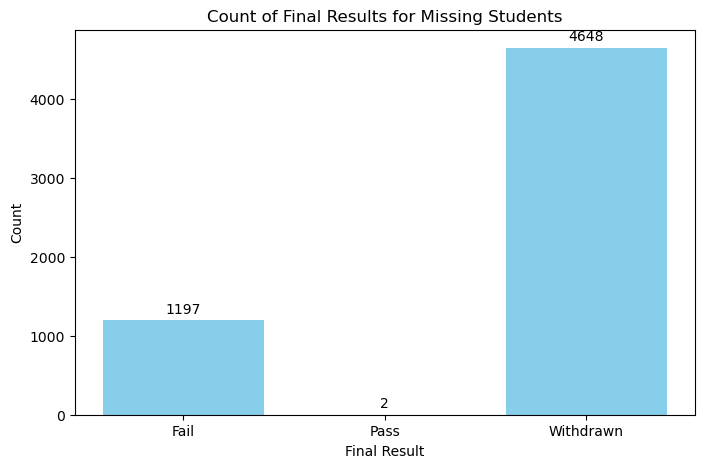

In [73]:
# What are their final results?
unique, counts = np.unique(missing_students['final_result'], return_counts = True)
dict(zip(unique, counts))

plot_bar_with_annotations(
    categories=unique,
    counts=counts,
    xlabel='Final Result',
    ylabel='Count',
    title='Count of Final Results for Missing Students',
    rotation=0
)

In [ ]:
# Display the missing student with final result as 'Pass'.
missing_students[missing_students['final_result'] == 'Pass']

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
645,AAA,2014J,1336190,M,London Region,HE Qualification,80-90%,55<=,0,60,N,Pass
12893,CCC,2014J,1777834,F,East Anglian Region,A Level or Equivalent,80-90%,35-55,0,60,N,Pass


Most of the missing students have either withdrawn or failed, with only two having passed. This is unusual since there are two students who have no recorded submissions yet are marked as having passed their modules. This likely indicates an error in the dataset.

In [79]:
missing_students_reg = studentRegistration[studentRegistration['id_student'].isin(missing_ids.index)]
missing_students_reg.head(10)

,code_module,code_presentation,id_student,date_registration,date_unregistration
2,AAA,2013J,30268,-92.0,12.0
44,AAA,2013J,135335,-29.0,30.0
118,AAA,2013J,281589,-50.0,NaN
125,AAA,2013J,292923,-162.0,-121.0
136,AAA,2013J,305539,-54.0,-3.0
169,AAA,2013J,346843,-44.0,NaN
171,AAA,2013J,354858,-32.0,5.0
198,AAA,2013J,405961,-170.0,-100.0
209,AAA,2013J,494424,-38.0,NaN
256,AAA,2013J,1763015,-58.0,-2.0


In [80]:
missing_students_reg['date_unregistration'].notnull().sum()

4594

Another issue with this dataset is the discrepancy in the number of withdrawn students. In the `studentInfo` table, there are 4,648 students marked as withdrawn, whereas in the `studentRegistration` table, the count of students with a non-null `date_unregistration` is 4,594, resulting in a difference of 54 students without an assigned unregistered date.

In [ ]:
studentRegistration[studentRegistration['id_student'] == 1336190]

,code_module,code_presentation,id_student,date_registration,date_unregistration
645,AAA,2014J,1336190,-23.0,NaN


In [82]:
studentRegistration[studentRegistration['id_student'] == 1777834]

,code_module,code_presentation,id_student,date_registration,date_unregistration
12893,CCC,2014J,1777834,NaN,NaN


The two students from the missing student list do not have a recorded unregistration date, which means they have not withdrawn.

## Student Info Table

This table provides demographic details about the students along with their academic outcomes. It includes the following columns:

* **code\_module**: A unique code representing the module the student is enrolled in.
* **code\_presentation**: The specific presentation (e.g., semester and year) during which the student is taking the module.
* **id\_student**: A unique identifier for each student.
* **gender**: The gender of the student.
* **region**: The geographic area where the student resided while taking the module.
* **highest\_education**: The highest level of education the student had completed upon starting the module.
* **imd\_band**: The Index of Multiple Deprivation band corresponding to the student's place of residence during the module.
* **age\_band**: The age range into which the student falls.
* **num\_of\_prev\_attempts**: The number of times the student has previously taken the module.
* **studied\_credits**: The total number of credits the student was enrolled in at the time.
* **disability**: Indicates whether the student declared any disabilities.
* **final\_result**: The final outcome of the student in that module presentation.


In [93]:
studentInfo.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass


In [95]:
studentInfo.describe()

,id_student,num_of_prev_attempts,studied_credits
count,3.259300e+04,32593.000000,32593.000000
mean,7.066877e+05,0.163225,79.758691
std,5.491673e+05,0.479758,41.071900
min,3.733000e+03,0.000000,30.000000
25%,5.085730e+05,0.000000,60.000000
50%,5.903100e+05,0.000000,60.000000
75%,6.444530e+05,0.000000,120.000000
max,2.716795e+06,6.000000,655.000000


### Missing, Duplicate, and Distinct Values Overview

In [94]:
print('Total null values: \n', studentInfo.isnull().sum(), '\n')
print('Total duplicated values:', studentInfo[studentInfo.duplicated()], '\n')
print('Total unique values: \n', studentInfo.nunique())

Total null values: 
 code_module                0
code_presentation          0
id_student                 0
gender                     0
region                     0
highest_education          0
imd_band                1111
age_band                   0
num_of_prev_attempts       0
studied_credits            0
disability                 0
final_result               0
dtype: int64 

Total duplicated values: Empty DataFrame
Columns: [code_module, code_presentation, id_student, gender, region, highest_education, imd_band, age_band, num_of_prev_attempts, studied_credits, disability, final_result]
Index: [] 

Total unique values: 
 code_module                 7
code_presentation           4
id_student              28785
gender                      2
region                     13
highest_education           5
imd_band                   10
age_band                    3
num_of_prev_attempts        7
studied_credits            61
disability                  2
final_result                4
dtype:

There are 1,111 entries where the *imd\_band* information is missing. Another notable observation is that although there are 32,593 student records in total, only around 28,785 of them represent unique students. This indicates that some student IDs appear multiple times, likely because those students switched to different modules or presentations.

### Data Types and Schema Overview

In [96]:
studentInfo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32593 entries, 0 to 32592
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   code_module           32593 non-null  object
 1   code_presentation     32593 non-null  object
 2   id_student            32593 non-null  int64 
 3   gender                32593 non-null  object
 4   region                32593 non-null  object
 5   highest_education     32593 non-null  object
 6   imd_band              31482 non-null  object
 7   age_band              32593 non-null  object
 8   num_of_prev_attempts  32593 non-null  int64 
 9   studied_credits       32593 non-null  int64 
 10  disability            32593 non-null  object
 11  final_result          32593 non-null  object
dtypes: int64(3), object(9)
memory usage: 3.0+ MB


In [97]:
studentInfo['id_student'] = studentInfo['id_student'].astype(object)

## VLE Table

The table provides details about the materials available in the Virtual Learning Environment (VLE). These materials typically include HTML pages, PDF documents, and similar resources. Students can access these materials online, and their interactions with them are tracked. The table contains the following columns:

* **id\_site**: a unique identifier for each material.
* **code\_module**: the code representing the module.
* **code\_presentation**: the code representing the presentation.
* **activity\_type**: the role or type associated with the module material.
* **week\_from**: the starting week when the material is intended to be used.
* **week\_to**: the ending week until which the material is planned to be available.


In [83]:
vle.head()

,id_site,code_module,code_presentation,activity_type,week_from,week_to
0,546943,AAA,2013J,resource,NaN,NaN
1,546712,AAA,2013J,oucontent,NaN,NaN
2,546998,AAA,2013J,resource,NaN,NaN
3,546888,AAA,2013J,url,NaN,NaN
4,547035,AAA,2013J,resource,NaN,NaN


### Missing, Duplicate, and Distinct Values Overview

In [85]:
print('Total null values: \n', vle.isnull().sum(), '\n')
print('Total duplicated values:', vle[vle.duplicated()], '\n')
print('Total unique values: \n', vle.nunique())

Total null values: 
 id_site                 0
code_module             0
code_presentation       0
activity_type           0
week_from            5243
week_to              5243
dtype: int64 

Total duplicated values: Empty DataFrame
Columns: [id_site, code_module, code_presentation, activity_type, week_from, week_to]
Index: [] 

Total unique values: 
 id_site              6364
code_module             7
code_presentation       4
activity_type          20
week_from              30
week_to                30
dtype: int64


### Data Types and Schema Overview

In [86]:
vle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6364 entries, 0 to 6363
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id_site            6364 non-null   int64  
 1   code_module        6364 non-null   object 
 2   code_presentation  6364 non-null   object 
 3   activity_type      6364 non-null   object 
 4   week_from          1121 non-null   float64
 5   week_to            1121 non-null   float64
dtypes: float64(2), int64(1), object(3)
memory usage: 298.4+ KB


In [87]:
vle['id_site'] = vle['id_site'].astype(object)

## Student VLE Table

The `studentVle` table records how students interact with online learning materials available in the VLE. It includes the following columns:

* **code\_module**: A code identifying the module.
* **code\_presentation**: A code identifying the specific presentation of the module.
* **id\_student**: A unique ID assigned to each student.
* **id\_site**: A unique ID for each VLE resource or material.
* **date**: The day (relative to the module's start date) on which the interaction occurred.
* **sum\_click**: The total number of times the student interacted with the material on that particular day.


In [88]:
studentVle.head()

,code_module,code_presentation,id_student,id_site,date,sum_click
0,AAA,2013J,28400,546652,-10,4
1,AAA,2013J,28400,546652,-10,1
2,AAA,2013J,28400,546652,-10,1
3,AAA,2013J,28400,546614,-10,11
4,AAA,2013J,28400,546714,-10,1


### Missing, Duplicate, and Distinct Values Overview

In [89]:
print('Total null values: \n', studentVle.isnull().sum(), '\n')
print('Total duplicated values:', studentVle[studentVle.duplicated()], '\n')
print('Total unique values: \n', studentVle.nunique())

Total null values: 
 code_module          0
code_presentation    0
id_student           0
id_site              0
date                 0
sum_click            0
dtype: int64 

Total duplicated values:          code_module code_presentation  id_student  id_site  date  sum_click
2                AAA             2013J       28400   546652   -10          1
63               AAA             2013J       45462   546652   -10          1
180              AAA             2013J       77367   546652   -10          4
193              AAA             2013J       94961   546652   -10          2
442              AAA             2013J      248270   546652   -10          4
...              ...               ...         ...      ...   ...        ...
10655235         GGG             2014J      686194   897083   267          1
10655250         GGG             2014J      676071   896939   268          1
10655256         GGG             2014J      642905   896939   268          2
10655261         GGG           

This dataset contains duplicate entries, but it's not a significant concern because students may interact with the VLE multiple times in a single day. Each interaction may be recorded separately, so multiple records for the same student on the same day are expected.

### Data Types and Schema Overview

In [90]:
studentVle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10655280 entries, 0 to 10655279
Data columns (total 6 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   code_module        object
 1   code_presentation  object
 2   id_student         int64 
 3   id_site            int64 
 4   date               int64 
 5   sum_click          int64 
dtypes: int64(4), object(2)
memory usage: 487.8+ MB


In [91]:
studentVle['id_student'] = studentVle['id_student'].astype(object)
studentVle['id_site'] = studentVle['id_site'].astype(object)

# Preprocess Data